<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Anomaly Detection
</h1><br>
<p align='center'>
<img src='images/outlier.jpg' height='1000px' width='500px'>
</p>

In [1]:
# Import libraries
import numpy as np
from numpy.linalg import pinv, det
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat, whosmat
import scipy.optimize as opt
import seaborn as sns
from warnings import filterwarnings

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')
filterwarnings('ignore')

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Functions
</h2><br>
We'll write here all the functions needed.

In [2]:
# Compute guassian distribution fn
def gaussian_estimate(X_train, X_val, gaussian_type='univariate'):
    '''
    parameters
    ----------
    X_train: array-like
        training features matrix m x n that has only normal examples.
    X_val: array-like
        cross validation features matrix that has anomalous and normal
        examples.
    gussian_type: str
        univariate or multivariate.
    
    Returns
    -------
    pdf: array-like
        multivariate pdf vector of n x 1
    '''
    # number of training examples and features
    m, n = X_train.shape
    # number of cv examples
    mval = X_val.shape[0]

    # compute mean and covariance matrix
    mu = X_train.mean(axis=0)
    cov = (1 / (m)) * (X_train - mu).T.dot(X_train - mu)

    # convert the covariance matrix to diagonal if it's a univariate
    if gaussian_type == 'univariate':
        z = np.zeros_like(cov)
        np.fill_diagonal(z, np.diagonal(cov))
        cov = z

    # compute determinant and inverse of covariance matrix
    cov_det = det(cov)
    cov_inv = pinv(cov)

    # compute pdf vector
    pdf = ((2 * np.pi) ** (-n / 2)) * (cov_det ** (-0.5)) *\
        np.exp(-0.5 * np.sum(np.multiply((X_val - mu).dot(cov_inv),
                                         (X_val - mu)), axis=1))

    return pdf


# Hyperparameter tuning of epsilon using cv dataset
def select_threshold(y_val, p_val):
    '''
    parameters
    ----------
    y_val: array-like
        label whether a validation example is normal (0) or anomaly (1).
    p_val: array-like
        pdf for validated examples.
    
    Returns
    -------
    eplsion : float
        best epsilon value tuned on validation data.
    F1_score : float
        F1 score using epsilon tuned on validation data.
    '''
    # initialize epsilon and F1 score values
    best_epsilon = 0
    best_F1 = 0

    # compute stepsize for each iteration
    epsilon_stepsize = (p_val.max() - p_val.min()) / 1000

    for epsilon in np.arange(p_val.min(), p_val.max(), epsilon_stepsize):
        # get predictions vector
        pred = ((p_val < epsilon) * 1).reshape(-1, 1)

        # compute true positives, false positives, false negatives
        tp = np.sum((pred == 1) & (y_val == 1))
        fp = np.sum((pred == 1) & (y_val == 0))
        fn = np.sum((pred == 0) & (y_val == 1))

        # compute precision and recall
        precision_ = tp / (tp + fp)
        recall_ = tp / (tp + fn)

        # compute F1 score
        F1 = 2 * ((precision_ * recall_) / (precision_ + recall_))
        # if F1 score > best_F1, set best_F1 = F1
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon

    return best_epsilon, best_F1

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Anomaly Detection
</h2><br>
Anomaly Detection is the identification of examples or events that don't confront to an expected pattern or the majority of examples. Roughly speaking, it's the process of identifying an example that is not *normal (outlier)* given the distribution of the data. **Outlier** is an example that deviates so much from the other examples that arouse suspicions that it was generated by different data generating process. Mainly, such outliers would have a very low probability (on the very end of both left and right tails of the probability density function) that they belong to the same data generating process.

The algorithm works as follows:
1. Fit a *Gaussian Probability Density Function (PDF)* for each feature in the training dataset.
    1. Calculate the mean and the variance of each feature:
    $$\mu_j = \frac{1}{m}\sum_{i = 1}^mx_j^i\\{}$$
    $$\sigma^2_j = \frac{1}{m}\sum_{i = 1}^m(x_j^i - \mu_j)^2\\{}$$
    Where $\mu$ is the mean and $\sigma^2$ is the variance that controls the shape of the density function.
    2. Compute the density function for each feature using the following formula:   
$$p(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x - \mu)^2}{2\sigma^2}}\\{}$$
Since the mean and the variance are sensitive to outliers, we use training dataset that has only normal examples to fit the model and calculate both the mean vector and the covariance matrix.
2. Compute the gaussian density by taking the product of all features' density functions.
3. If $p(x) < \epsilon$ then anomaly; otherwise, normal. Epsilon controls how sensitive the detection algorithm is. If $\epsilon$ is large $\rightarrow$ flag a lot of the examples as anomalous and that would increase the *False Positives*. However, If $\epsilon$ is small $\rightarrow$ very small portion of the examples will be flagged as anomalous and that would increase the *False Negatives*.
4. Use *Cross Validation* for tuning the hyper-parameter $\epsilon$ that yields the best performance metrics value. F1 score is commonly used:
$$F_1 = 2 \frac{precision * recall}{precision + recall}\\{}$$
Where:$$precision = \frac{tp}{tp + fp}\\{}$$
$$recall = \frac{tp}{tp + fn}\\{}$$
*tp: True Positive, fp: False Positive, fn: False Negative*.

We have two kinds of anomaly detection algorithms:
1. **Univariate Gaussian Density Function**
$$p(x) = \prod_{j = 1}^{n}p(x_j; \mu_j, \sigma_j^2)\\{}$$
$$ = p(x_1; \mu_1, \sigma_1^2)*p(x_2; \mu_2, \sigma_2^2)* ... * p(x_n; \mu_n, \sigma_j^n)\\{}$$
    * It assumes that all features are independent. Therefore, the covariance between all pairs of features is zero.
    * It's computationally faster and more efficient.
    * Use it if we have very large number of features.
    * Make sure to add features manually that captures unusual values for combination of features; such as $x_3 = \frac {x_2}{x_1}$. Otherwise, the algorithm may fail to detect anomalies that takes values that are considered normal when looked at each feature separately but are unusual when looking at values of all features together such as having high value for feature 2 compared to low value for feature 1.

2. **Multivariate Gaussian Density Function**
$$p(x) = \prod_{j = 1}^{n}p(x_j; \mu_j, \sigma_j^2)\\{}$$
$$p(x; \mu, \sigma^2) = \frac{1}{(2\pi)^{(n / 2)}(\det\sum)^{1 / 2}}e^{\frac{-1}{2}(x - \mu)^T\sum^{-1}(x - \mu)}\\{}$$
Where $\sum$ is n x n covariance matrix:
$$\sum = \begin{bmatrix}
\sigma_1^2&\sigma_{12}&\cdots&\sigma_{1n}\\
\sigma_{21}&\sigma_2^2&\cdots&0\\
\vdots & \vdots & \ddots & \vdots \\
\sigma_{n1} & 0 & 0 & \sigma_n^2
\end{bmatrix}$$
Where $\sigma_{12} = \sigma_{21}$ is the covariance between features 1&2. Therefore, the covariance matrix is *symmetric positive (semi) definite*.
    * Computationally expensive
    * Use it when number of examples $\geq$ 10 times number of features, i.e. $m \geq 10n$
    * If some features are linearly dependent or number of examples is less than number of features $\rightarrow$ covariance matrix won't be invertible
    * No need to add more features to capture unusual values of combination of features because it captures that through covariances of all pairs of features
    * Univariate density function can be derived from Multivariate density function where covariance matrix would be a diagonal matrix. Therefore, $\sigma_{ij} = 0$ for all $i \neq j$

There are some assumptions made implicitly here:
- For each feature, $X_i$'s are IID (independently and identically distributed).
- Using Central Theorem (CLT): the distribution of sum of iid random variable are approximately normal. Therefore, this would allow us to fit normal distribution that's parameterized by $\mu$ and $\sigma^2$.
- $\mu$ and $\sum$ will be estimated using maximum-likelihood estimation method.

When fitting multivariate probability distribution using the above assumptions, we'll use that pdf to estimate the probability that each example from the validation/test set was generated by this pdf. If the probability is smaller that $\epsilon$, then we believe that such example was generated by different mutlivariate PDF and, therefor, classified as *anomaly* (outlier).

In this exercise, we'll implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While servers were operating, $m = 307$ examples of how they were behaving were captured. We suspect that the vast majority of them are normal (non-anomalous) examples of the servers operating normally.

Let's first load and plot the data:

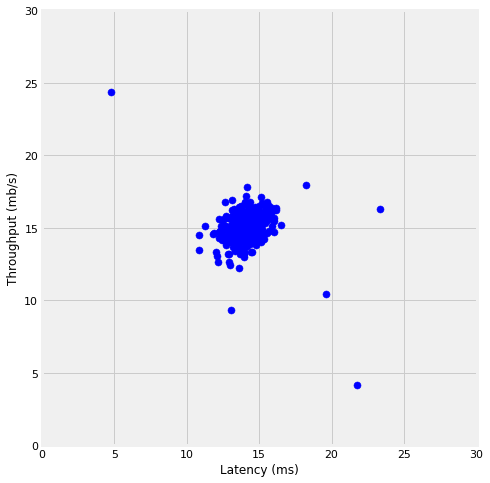

In [3]:
# Load data
data = loadmat('../data/servers_anomaly_detection.mat')

# Training data
X = data['X']

# Cross validation data
X_val = data['Xval']
y_val = data['yval']

# Plot data
fig, ax = plt.subplots(figsize = (8, 8))
plt.scatter(X[:, 0], X[:, 1], s = 50, c = 'blue')
plt.axis([0, 30, 0, 30])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.gca().set_aspect('equal')
# plt.title('Scatter plot of the first dataset');

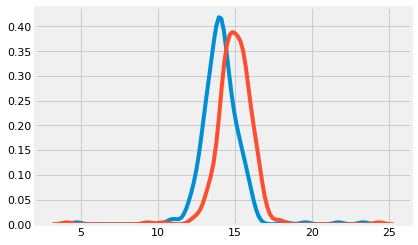

In [4]:
# plt.subplots(1, 2, 1)
sns.kdeplot(X[:, 0])
sns.kdeplot(X[:, 1])

Now, we'll first estimate the Gaussian distribution for both the training and cross validation sets. Note that we use training dataset that has ONLY normal examples when computing mean and covariance and then use cross validation that has both normal and anomalous examples to know the best epsilon.

In [7]:
# Fit guassian distribution on both training and CV examples
ptrain = gaussian_estimate(X, X)
pval = gaussian_estimate(X, X_val, gaussian_type='multivariate')

# Tune epsilon
epsilon, F1 = select_threshold(y_val, pval)
print(f'The best epsilon tuned using CV that yielded the best' +
      f'F1-score {F1:.3f} is: {epsilon}.')

The best epsilon tuned using CV that yielded the bestF1-score 0.875 is: 9.065769728392737e-05.


We'll use the value of epsilon that we tuned using CV to see what examples were anomalous based on our algorithm. Below is the scatter plot of the training data where red points are anomalous examples. 

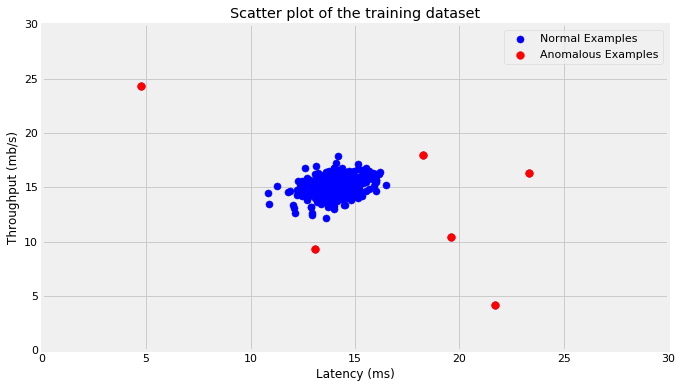

In [8]:
# Get the index of the outlier
outliers = np.where(ptrain < epsilon)

# Plot data
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=50, c='blue', label='Normal Examples')
plt.scatter(X[outliers[0], 0], X[outliers[0], 1], s=60, c='red', label='Anomalous Examples')
plt.axis([0, 30, 0, 30])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.legend(loc='upper right')
plt.title('Scatter plot of the training dataset');

Finally, we'll try to fit Gaussian distribution on training dataset that has 1000 examples and 11 features. Note that in both examples we used *Multivariate* not *Univariate* Gaussian distribution. 

In [10]:
# Load data
data = loadmat('../data/ex8data2.mat')

# Training data
X = data['X']

# Cross validation data
Xval = data['Xval']
yval = data['yval']

# Fit guassian distribution on both training and CV examples
ptrain = gaussian_estimate(X, X, gaussian_type='multivariate')
pval = gaussian_estimate(X, Xval, gaussian_type='multivariate')

# Tune epsilon
epsilon, F1 = select_threshold(yval, pval)
print(f'The best epsilon tuned using CV that yielded the best' + \
      'F1-score {F1:.3f} is: {epsilon}.')

The best epsilon tuned using CV that yielded the bestF1-score {F1:.3f} is: {epsilon}.


Using the best-epsilon value we got above, we can then classify any example as anomaly if $p(x) < \epsilon$; otherwise, it's normal.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Conclusion
</h2><br>
* The implementation of the variance/covariance in the detection algorithms has $m$ in the denominator not $(m - 1)$ because with large datasets this doesn't make a difference. However, the unbiased estimator of the variance should have $(m - 1)$ in the denominator not $m$.
* Anomaly detection vs Supervised learning:
    * Use Anomaly Detection when you have large number of negative examples and very small number of positive examples. The reason is because the supervised learning algorithm wouldn't be able to have enough examples to learn about the scene especially if the future anomalies are nothing like training anomalies
    * Use Supervised Learning algorithms such as logistic regression if you have enough positive examples that make the learning easy on the algorithm  and probably it would outperform Anomaly Detection algorithms.  
* Univariate PDF performs well most of the times compared to Multivariate PDF and scale really well.